<a href="https://colab.research.google.com/github/WilliamJWen/Project42/blob/main/colab_notebooks/model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Project42: AI generated Image Detector**



# Data Preprocessing

In [1]:
# mount our Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/Project 42

/content/drive/.shortcut-targets-by-id/10mb1gPJLJgRacbxehHwFsW4qyNo6j-JS/Project 42


In [ ]:
ls

 ChameleonDataset/  'Ethical Considerations.gdoc'  'Untitled Diagram.drawio'
 Chameleon.zip       processedChameleon/


### Preprocess Chameleon Dataset
- step 1: half of the real images (75-20-5)
- step 2: half of the real images (70-20-5) and same amount of the fake images (75-20-5)

In [ ]:
# #######################################
# #### NO NEED TO RUN THIS PART AGAIN ####
# ########################################

# import zipfile

# zip_path = '/content/drive/MyDrive/Project 42/Chameleon.zip'
# extract_to = '/content/destination_folder'

# with zipfile.ZipFile(zip_path, 'r') as zip_ref:
#     zip_ref.extractall(extract_to)


In [ ]:
# #######################################
# #### NO NEED TO RUN THIS PART AGAIN ####
# ########################################

# import os
# import random
# import shutil
# from math import floor

# # -----------------------------
# # 1. Define Paths
# # -----------------------------
# # Path to the original dataset containing:
# #   - "1_real"
# #   - "2_fake"
# dataset_dir = "/content/destination_folder/Chameleon/test"  # CHANGE to your dataset location

# # Output directories for each step
# output_step1 = "/content/drive/MyDrive/Project 42/processedChameleon/step1"  # for step 1 (real only)
# output_step2 = "/content/drive/MyDrive/Project 42/processedChameleon/step2"  # for step 2 (real + fake)

# # Directories of real and fake images
# real_dir = os.path.join(dataset_dir, "0_real")
# fake_dir = os.path.join(dataset_dir, "1_fake")

# # -----------------------------
# # 2. Gather Image File Paths
# # -----------------------------
# valid_exts = (".jpg", ".jpeg", ".png", ".bmp", ".tiff")

# real_images = [os.path.join(real_dir, f) for f in os.listdir(real_dir)
#                if f.lower().endswith(valid_exts)]
# fake_images = [os.path.join(fake_dir, f) for f in os.listdir(fake_dir)
#                if f.lower().endswith(valid_exts)]

# # Shuffle images to randomize splits
# random.shuffle(real_images)
# random.shuffle(fake_images)

# print(f"Found {len(real_images)} real images.")
# print(f"Found {len(fake_images)} fake images.")

# # -----------------------------
# # 3. Split Real Images into Two Halves
# # -----------------------------
# half_real_count = len(real_images) // 2
# real_half_1 = real_images[:half_real_count]  # for step 1
# real_half_2 = real_images[half_real_count:]  # for step 2

# # -----------------------------
# # 4. Define Splitting Functions
# # -----------------------------
# def split_75_20_5(image_list):
#     """
#     Splits a list of images into 75% train, 20% val, and 5% test.
#     """
#     total = len(image_list)
#     train_end = floor(total * 0.75)
#     val_end = floor(total * 0.95)  # 75% + 20% = 95%
#     train = image_list[:train_end]
#     val = image_list[train_end:val_end]
#     test = image_list[val_end:]
#     return train, val, test

# def split_exact(image_list):
#     """
#     Splits a list into exactly 75% train, 20% val, 5% test.
#     """
#     total = len(image_list)
#     train_end = floor(total * 0.75)
#     val_end = floor(total * 0.95)
#     train = image_list[:train_end]
#     val = image_list[train_end:val_end]
#     test = image_list[val_end:]
#     return train, val, test

# # -----------------------------
# # 5. Create Step 1 Splits (Real Only)
# # -----------------------------
# train_real_1, val_real_1, test_real_1 = split_75_20_5(real_half_1)

# # -----------------------------
# # 6. Create Step 2 Splits (Balanced Real + Fake)
# # -----------------------------
# # Ensure that we have an equal number of fake images to match real_half_2
# required_fake = len(real_half_2)
# if required_fake > len(fake_images):
#     raise ValueError("Not enough fake images to match the second half of real images.")

# # Use as many fake images as needed
# fake_for_step2 = fake_images[:required_fake]

# # Shuffle before splitting each class separately
# random.shuffle(real_half_2)
# random.shuffle(fake_for_step2)

# # Split each class individually
# train_real_2, val_real_2, test_real_2 = split_exact(real_half_2)
# train_fake,    val_fake,    test_fake    = split_exact(fake_for_step2)

# # Combine corresponding splits to ensure balance in each subset
# train_step2 = [(path, "real") for path in train_real_2] + [(path, "fake") for path in train_fake]
# val_step2   = [(path, "real") for path in val_real_2]   + [(path, "fake") for path in val_fake]
# test_step2  = [(path, "real") for path in test_real_2]  + [(path, "fake") for path in test_fake]

# # Shuffle the combined splits
# random.shuffle(train_step2)
# random.shuffle(val_step2)
# random.shuffle(test_step2)

# # -----------------------------
# # 7. Copy Files to Output Folders
# # -----------------------------
# def copy_files(file_list, output_dir, is_tuple=False):
#     """
#     Copies files to output_dir under subdirectories for each class.
#     If is_tuple is True, each item is a (filepath, label) tuple.
#     Otherwise, all files are assumed to be 'real'.
#     """
#     for item in file_list:
#         if is_tuple:
#             file_path, label = item
#         else:
#             file_path = item
#             label = "real"
#         dest_folder = os.path.join(output_dir, label)
#         os.makedirs(dest_folder, exist_ok=True)
#         file_name = os.path.basename(file_path)
#         shutil.copy2(file_path, os.path.join(dest_folder, file_name))

# # --- For Step 1 (real only) ---
# for split, files in zip(["train", "val", "test"], [train_real_1, val_real_1, test_real_1]):
#     out_dir = os.path.join(output_step1, split)
#     os.makedirs(out_dir, exist_ok=True)
#     copy_files(files, out_dir, is_tuple=False)

# # --- For Step 2 (balanced real and fake) ---
# for split, files in zip(["train", "val", "test"], [train_step2, val_step2, test_step2]):
#     out_dir = os.path.join(output_step2, split)
#     os.makedirs(out_dir, exist_ok=True)
#     copy_files(files, out_dir, is_tuple=True)

# print("Data successfully split and copied!")


Found 14863 real images.
Found 11170 fake images.
Data successfully split and copied!


Processed Data is at `/content/drive/MyDrive/Project\ 42/processedChameleon` now.

In [ ]:
!ls -1 /content/drive/MyDrive/Project\ 42/processedChameleon/step2/train/real | wc -l


5574


In [ ]:
import os
import torch
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils.data import DataLoader

# set seed
torch.random.manual_seed(42)


# Define base path to processedChameleon
base_dir = "/content/drive/MyDrive/Project 42/processedChameleon"
step2_dir = os.path.join(base_dir, "step2")

# Define directories for each split
train_dir = os.path.join(step2_dir, "train")
val_dir   = os.path.join(step2_dir, "val")
test_dir  = os.path.join(step2_dir, "test")

# Define image transforms
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

# Load datasets using ImageFolder
train_dataset = ImageFolder(root=train_dir, transform=transform)
val_dataset   = ImageFolder(root=val_dir, transform=transform)
test_dataset  = ImageFolder(root=test_dir, transform=transform)

# Create DataLoaders
batch_size = 64

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print("Step 2 Train classes:", train_dataset.classes)
print("Step 2 Train samples:", len(train_dataset))
print("Step 2 Validation samples:", len(val_dataset))
print("Step 2 Test samples:", len(test_dataset))


Step 2 Train classes: ['fake', 'real']
Step 2 Train samples: 11148
Step 2 Validation samples: 2972
Step 2 Test samples: 744


In [9]:
import os
import torch
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils.data import DataLoader, random_split


def get_data_loaders(step, batch_size=64):
  # Define base path to processedChameleon
  base_dir = "/content/drive/MyDrive/Project 42/processedChameleon"
  step_dir = os.path.join(base_dir, "step" + str(step))

  # Define directories for each split
  train_dir = os.path.join(step_dir, "train")
  val_dir   = os.path.join(step_dir, "val")
  test_dir  = os.path.join(step_dir, "test")

  # Define image transforms
  transform = transforms.Compose([
      transforms.Resize((256, 256)),
      transforms.ToTensor(),
      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
  ])

  # Load datasets using ImageFolder
  train_dataset = ImageFolder(root=train_dir, transform=transform)
  val_dataset   = ImageFolder(root=val_dir, transform=transform)
  test_dataset  = ImageFolder(root=test_dir, transform=transform)

  train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
  val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
  test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

  return train_loader, val_loader, test_loader


def get_small_batch(step, size):
  # Get path to training data
  base_dir = "/content/drive/MyDrive/Project 42/processedChameleon"
  step_dir = os.path.join(base_dir, "step" + str(step))
  train_dir = os.path.join(step_dir, "train")

  # Define image transforms
  transform = transforms.Compose([
      transforms.Resize((256, 256)),
      transforms.ToTensor(),
      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
  ])

  # Create dataloader
  data = ImageFolder(root=train_dir, transform=transform)
  batch, _ = random_split(data,
                          lengths=[size, len(data) - size],
                          generator=torch.Generator().manual_seed(42))

  return batch


# Baseline Model

## Architecture

In [ ]:
import torch.nn as nn
import torch.nn.functional as F


class Baseline(nn.Module):
  def __init__(self):
    super(Baseline, self).__init__()

    # Hidden layer activation
    self.activation = F.relu

    # Pooling
    self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2) # 2w x 2h -> w x h
    self.avgpool4 = nn.AvgPool2d(kernel_size=4, stride=4) # 4w x 4h -> w x h

    # Convolutional layers
    self.conv1 = nn.Conv2d(in_channels=3,
                           out_channels=64,
                           kernel_size=7,
                           padding=3,
                           stride=2)
    self.conv2 = nn.Conv2d(in_channels=64,
                           out_channels=64,
                           kernel_size=3,
                           padding=1,
                           stride=1)
    self.conv3 = nn.Conv2d(in_channels=64,
                           out_channels=64,
                           kernel_size=3,
                           padding=1,
                           stride=1)
    self.conv4 = nn.Conv2d(in_channels=64,
                           out_channels=128,
                           kernel_size=3,
                           padding=1,
                           stride=2)
    self.conv5 = nn.Conv2d(in_channels=128,
                           out_channels=128,
                           kernel_size=3,
                           padding=1,
                           stride=1)
    self.conv6 = nn.Conv2d(in_channels=128,
                           out_channels=256,
                           kernel_size=3,
                           padding=1,
                           stride=2)
    self.conv7 = nn.Conv2d(in_channels=256,
                           out_channels=256,
                           kernel_size=3,
                           padding=1,
                           stride=1)

    # FC layer
    self.fc = nn.Linear(256 * 4 * 4, 1)

    # Batch normalization
    self.norm64 = nn.BatchNorm2d(num_features=64)
    self.norm128 = nn.BatchNorm2d(num_features=128)
    self.norm256 = nn.BatchNorm2d(num_features=256)


  def downsample2(self, x, out_channels):
    N, C, H, W = x.shape # Assume H == W

    # Downsample by 2
    downsample = nn.AvgPool2d(2, 2)
    x = downsample(x)

    # 0 padding new channels
    new_channels = out_channels - C
    x = F.pad(x, pad=(0, 0, 0, 0, 0, new_channels))

    return x


  def forward(self, x):
    # Layer 1
    x = self.conv1(x)                                       # Output: 64x128x128
    x = self.norm64(self.activation(self.maxpool2(x)))      # Output: 64x64x64

    # Layer 2
    skip = x.detach().clone()
    x = self.norm64(self.activation(self.conv2(x)))         # Output: 64x64x64

    # Layer 3
    x = self.norm64(self.activation(skip + self.conv3(x)))  # Output: 64x64x64

    # Layer 4
    skip = x.detach().clone()
    x = self.norm128(self.conv4(x))                         # Output: 128x32x32

    # Layer 5
    x = self.norm128(self.activation(self.downsample2(skip, 128)
                                      + self.conv5(x)))     # Output: 128x32x32

    # Layer 6
    skip = x.detach().clone()
    x = self.norm256(self.activation(self.conv6(x)))        # Output: 256x16x16

    # Layer 7
    x = self.downsample2(skip, 256) + self.conv7(x)         # Output: 256x16x16
    x = self.norm256(self.activation(self.avgpool4(x)))     # Output: 256x4x4

    # Layer 8
    x = x.view(-1, 256 * 4 * 4)
    x = self.fc(x)
    x = x.squeeze(1)

    return x


baseline_model = Baseline()
num_params = 0
for param in baseline_model.parameters():
    num_params += param.numel()
print("There are", num_params, "parameters in the baseline model")


There are 1195009 parameters in the baseline model


## Training

### Functions

In [ ]:
import matplotlib.pyplot as plt
import torch


# Plot training curve from model path
def plot_training_curve(path):
  train_err = np.loadtxt("{}_train_err.csv".format(path))
  val_err = np.loadtxt("{}_val_err.csv".format(path))
  train_loss = np.loadtxt("{}_train_loss.csv".format(path))
  val_loss = np.loadtxt("{}_val_loss.csv".format(path))
  plt.title("Train vs Validation Error")
  n = len(train_err) # number of epochs
  plt.plot(range(1, n + 1), train_err, label="Train")
  plt.plot(range(1, n + 1), val_err, label="Validation")
  plt.xlabel("Epoch")
  plt.ylabel("Error")
  plt.legend(loc='best')
  plt.show()
  plt.title("Train vs Validation Loss")
  plt.plot(range(1, n + 1), train_loss, label="Train")
  plt.plot(range(1, n + 1), val_loss, label="Validation")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.legend(loc='best')
  plt.show()


In [ ]:
import numpy as np
import time
import torch.optim as optim
from torch.utils.data import DataLoader


# Path that I (Nathan) use to save files; replace with your own folder if you
# want to run
NATHAN_PATH = '/content/drive/MyDrive/APS360_misc/'


# Get name of baseline model checkpoint
def get_baseline_name(epoch):
  path = NATHAN_PATH + "model_baseline_epoch{0}".format(epoch)
  return path


# Evaluate data from loader on net
def evaluate_baseline(net, loader):
  if loader == None:
    return None, None

  # Enable GPU usage
  if torch.cuda.is_available():
    net = net.cuda()

  total_loss = 0.0
  total_err = 0.0
  num_samples = 0

  criterion = nn.BCEWithLogitsLoss()

  for i, data in enumerate(loader):
    imgs, labels = data
    num_samples += len(labels)

    # Enable GPU usage
    if torch.cuda.is_available():
      imgs = imgs.cuda()
      labels = labels.cuda()

    # Forward pass
    outputs = net(imgs)
    loss = criterion(outputs, labels.float())

    # Update loss, error
    corr = (outputs > 0.0).squeeze().long() != labels
    total_err += int(corr.sum())
    total_loss += loss.item()

  err = float(total_err) / num_samples
  loss = float(total_loss) / len(loader)

  return err, loss


# Train baseline model on given datasets
def train_baseline(net,
                   custom_train=None,
                   num_epochs=17):
  torch.manual_seed(42)

  # Note: we want to train over 3000 iterations. For now, I assume a batch size
  # of 11148, meaning there will be 175 iterations/per epoch, so I am using 17
  # epochs.

  # Enable GPU usage
  if torch.cuda.is_available():
    net = net.cuda()

  # Hyperparameters
  batch_size = 64
  learning_rate = 0.01

  # Criterion
  criterion = nn.BCEWithLogitsLoss()

  # Optimizer
  betas = (0.9, 0.99)
  optimizer = optim.Adam(net.parameters(),
                         lr=learning_rate,
                         betas=betas)

  # Arrays to record loss and error
  train_err = np.zeros(num_epochs)
  train_loss = np.zeros(num_epochs)
  val_err = np.zeros(num_epochs)
  val_loss = np.zeros(num_epochs)

  # Load data
  train_loader, val_loader, _ = get_data_loaders(step=2, batch_size=batch_size)
  if custom_train:
    train_loader = DataLoader(custom_train, batch_size, shuffle=True)
    val_loader = None

  # Train
  start_time = time.time()
  for epoch in range(num_epochs):
    total_train_loss = 0.0
    total_train_err = 0.0
    num_samples = 0

    # Iterate through mini batches
    for i, data in enumerate(train_loader):
      imgs, labels = data
      num_samples += len(labels)

      # Enable GPU usage
      if torch.cuda.is_available():
        imgs = imgs.cuda()
        labels = labels.cuda()

      # Forward pass, backward pass, update
      optimizer.zero_grad()
      outputs = net(imgs)
      loss = criterion(outputs, labels.float())
      loss.backward()
      optimizer.step()

      # Update training loss, error
      corr = (outputs > 0.0).squeeze().long() != labels
      total_train_err += int(corr.sum())
      total_train_loss += loss.item()

    # Calculate total loss, error
    train_err[epoch] = total_train_err / num_samples
    train_loss[epoch] = total_train_loss / len(train_loader)
    val_err[epoch], val_loss[epoch] = evaluate_baseline(net, val_loader)

    # Print loss, error
    print(("Epoch {}: Train err: {}, Train loss: {} | " +
           "Validation err: {}, Validation loss: {}").format(
              epoch + 1,
              train_err[epoch],
              train_loss[epoch],
              val_err[epoch],
              val_loss[epoch]))

    # Save the current model (checkpoint) to a file
    model_path = get_baseline_name(epoch + 1)
    torch.save(net.state_dict(), model_path)

  # Finish up
  print('Finished Training')
  end_time = time.time()
  elapsed_time = end_time - start_time
  print("Total time elapsed: {:.2f} seconds".format(elapsed_time))

  # Write the train/test loss/err into CSV file for plotting later
  np.savetxt("{}_train_err.csv".format(model_path), train_err)
  np.savetxt("{}_train_loss.csv".format(model_path), train_loss)
  np.savetxt("{}_val_err.csv".format(model_path), val_err)
  np.savetxt("{}_val_loss.csv".format(model_path), val_loss)


### Overfit

In [ ]:
overfit_model = Baseline()
train_baseline(overfit_model,
               custom_train=get_small_batch(step=2, size=64),
               num_epochs=200)

Epoch 1: Train err: 0.46153846153846156, Train loss: 0.7196691036224365 | Validation err: nan, Validation loss: nan
Epoch 2: Train err: 0.24615384615384617, Train loss: 0.8714367151260376 | Validation err: nan, Validation loss: nan
Epoch 3: Train err: 0.5692307692307692, Train loss: 4.921142578125 | Validation err: nan, Validation loss: nan
Epoch 4: Train err: 0.26153846153846155, Train loss: 1.6515369415283203 | Validation err: nan, Validation loss: nan
Epoch 5: Train err: 0.27692307692307694, Train loss: 2.2580249309539795 | Validation err: nan, Validation loss: nan
Epoch 6: Train err: 0.3384615384615385, Train loss: 1.636460304260254 | Validation err: nan, Validation loss: nan
Epoch 7: Train err: 0.2, Train loss: 0.6958973407745361 | Validation err: nan, Validation loss: nan
Epoch 8: Train err: 0.2153846153846154, Train loss: 0.5696911215782166 | Validation err: nan, Validation loss: nan
Epoch 9: Train err: 0.24615384615384617, Train loss: 0.5143063068389893 | Validation err: nan, V

### Train

In [ ]:
baseline_model = Baseline()
train_baseline(baseline_model)

Epoch 1: Train err: 0.3429007085837295, Train loss: 1.041461044549942 | Validation err: 0.4734185733512786, Validation loss: 1.20828308196778
Epoch 2: Train err: 0.29796394295452505, Train loss: 0.655928635597229 | Validation err: 0.43741588156123823, Validation loss: 0.8541179426172947
Epoch 3: Train err: 0.26692976948605257, Train loss: 0.5508073682444437 | Validation err: 0.43203230148048455, Validation loss: 0.830292080311065
Epoch 4: Train err: 0.24827338774778007, Train loss: 0.5207569835867201 | Validation err: 0.43337819650067294, Validation loss: 0.8359528488301217
Epoch 5: Train err: 0.2402906090232308, Train loss: 0.5069523736408779 | Validation err: 0.4165545087483176, Validation loss: 0.8298911591793628
Epoch 6: Train err: 0.22988608843842498, Train loss: 0.4900234472751617 | Validation err: 0.398721399730821, Validation loss: 0.8319046681231641
Epoch 7: Train err: 0.22773342900708585, Train loss: 0.4881461043017251 | Validation err: 0.4205921938088829, Validation loss: 0.

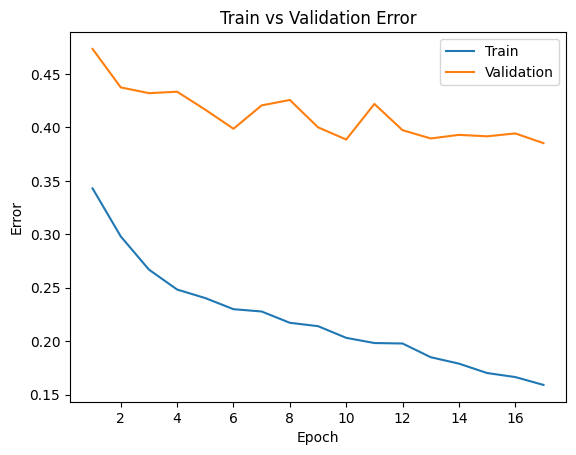

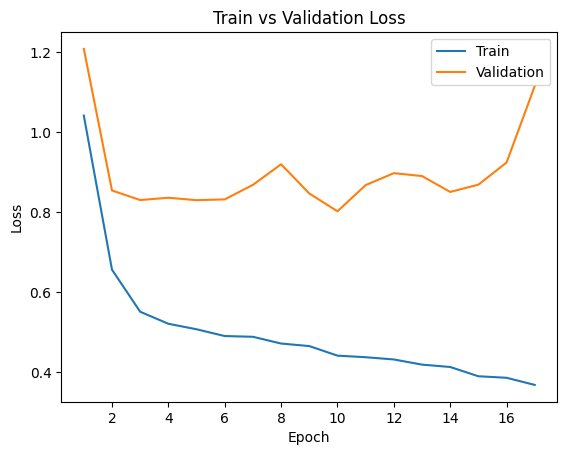

In [ ]:
plot_training_curve(get_baseline_name(epoch=17))

## Test

In [ ]:
net = Baseline()
model_path = get_baseline_name(epoch=17)
state = torch.load(model_path)
net.load_state_dict(state)

if torch.cuda.is_available():
    net = net.cuda()

_, _, test_loader = get_data_loaders(step=2)

test_error, _ = evaluate_baseline(net, test_loader)
print("The test classification accuracy is", 1 - test_error)

<ipython-input-29-b697d2521018>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(model_path)


The test classification accuracy is 0.6196236559139785


# Primary Model

## Step 1

### Architectures

In [23]:
import torch.nn as nn
import torch.nn.functional as F


class ConvAutoencoder(nn.Module):
  def __init__(self, name_suffix=None):
    super(ConvAutoencoder, self).__init__()

    self.name = "autoencoder"
    if name_suffix:
      self.name += "_" + name_suffix

    # Hidden layer activation
    self.activation = self.TRec

    # Encoder convolutional layers
    self.enc_conv1 = nn.Conv2d(in_channels=3,
                               out_channels=16,
                               kernel_size=3,
                               padding=1,
                               stride=2,
                               bias=False)
    self.enc_conv2 = nn.Conv2d(in_channels=16,
                               out_channels=16,
                               kernel_size=3,
                               padding=1,
                               stride=2,
                               bias=False)
    self.enc_conv3 = nn.Conv2d(in_channels=16,
                               out_channels=32,
                               kernel_size=3,
                               padding=1,
                               stride=2,
                               bias=False)
    self.enc_conv4 = nn.Conv2d(in_channels=32,
                               out_channels=64,
                               kernel_size=3,
                               padding=1,
                               stride=2,
                               bias=False)
    self.enc_conv5 = nn.Conv2d(in_channels=64,
                               out_channels=128,
                               kernel_size=3,
                               padding=1,
                               stride=2,
                               bias=False)
    self.enc_conv6 = nn.Conv2d(in_channels=128,
                               out_channels=256,
                               kernel_size=3,
                               padding=1,
                               stride=2,
                               bias=False)

    # Decoder convolutional layers
    self.dec_conv1 = nn.ConvTranspose2d(in_channels=256,
                                        out_channels=128,
                                        kernel_size=3,
                                        padding=1,
                                        output_padding=1,
                                        stride=2,
                                        bias=False)
    self.dec_conv2 = nn.ConvTranspose2d(in_channels=128,
                                        out_channels=64,
                                        kernel_size=3,
                                        padding=1,
                                        output_padding=1,
                                        stride=2,
                                        bias=False)
    self.dec_conv3 = nn.ConvTranspose2d(in_channels=64,
                                        out_channels=32,
                                        kernel_size=3,
                                        padding=1,
                                        output_padding=1,
                                        stride=2,
                                        bias=False)
    self.dec_conv4 = nn.ConvTranspose2d(in_channels=32,
                                        out_channels=16,
                                        kernel_size=3,
                                        padding=1,
                                        output_padding=1,
                                        stride=2,
                                        bias=False)
    self.dec_conv5 = nn.ConvTranspose2d(in_channels=16,
                                        out_channels=16,
                                        kernel_size=3,
                                        padding=1,
                                        output_padding=1,
                                        stride=2,
                                        bias=False)
    self.dec_conv6 = nn.ConvTranspose2d(in_channels=16,
                                        out_channels=3,
                                        kernel_size=3,
                                        padding=1,
                                        output_padding=1,
                                        stride=2,
                                        bias=False)

    # Batch normalization
    self.norm16 = nn.BatchNorm2d(num_features=16)
    self.norm32 = nn.BatchNorm2d(num_features=32)
    self.norm64 = nn.BatchNorm2d(num_features=64)
    self.norm128 = nn.BatchNorm2d(num_features=128)
    self.norm256 = nn.BatchNorm2d(num_features=256)


  # https://arxiv.org/pdf/1402.3337
  def TRec(self, x, threshold=1):
    # Can't find a way to do element-wise operation on GPU, so instead subtract
    # by threshold element-wise, apply ReLU, and add by threshold element-wise
    x = torch.sub(x, threshold)
    x = F.relu(x)
    x = torch.add(x, threshold)

    return x


  def encode(self, x):
    # Input: Nx3x256x256
    x = self.norm16(self.activation(self.enc_conv1(x)))   # Output: 16x128x128
    x = self.norm16(self.activation(self.enc_conv2(x)))   # Output: 16x64x64
    x = self.norm32(self.activation(self.enc_conv3(x)))   # Output: 32x32x32
    x = self.norm64(self.activation(self.enc_conv4(x)))   # Output: 64x16x16
    x = self.norm128(self.activation(self.enc_conv5(x)))  # Output: 128x8x8
    x = self.norm256(self.activation(self.enc_conv6(x)))  # Output: 256x4x4

    return x


  def decode(self, x):
    # Input: Nx128x4x4
    x = self.norm128(self.activation(self.dec_conv1(x)))  # Output: 128x8x8
    x = self.norm64(self.activation(self.dec_conv2(x)))   # Output: 64x16x16
    x = self.norm32(self.activation(self.dec_conv3(x)))   # Output: 32x32x32
    x = self.norm16(self.activation(self.dec_conv4(x)))   # Output: 16x64x64
    x = self.norm16(self.activation(self.dec_conv5(x)))   # Output: 16x128x128
    x = self.dec_conv6(x)                                 # Output: 3x256x256

    return x


  def forward(self, x):
    x = self.encode(x)
    x = self.decode(x)
    return x


autoencoder = ConvAutoencoder()
num_params = 0
for param in autoencoder.parameters():
    num_params += param.numel()
print("There are", num_params, "parameters in the autoencoder")


There are 789824 parameters in the autoencoder


### Training

#### Functions

In [4]:
import matplotlib.pyplot as plt
import torch


# Plot training curve from model path
def plot_training_curve_step1(path):
  train_loss = np.loadtxt("{}_train_loss.csv".format(path))
  val_loss = np.loadtxt("{}_val_loss.csv".format(path))
  n = len(train_loss) # number of epochs
  plt.title("Train vs Validation Loss")
  plt.plot(range(1, n + 1), train_loss, label="Train")
  plt.plot(range(1, n + 1), val_loss, label="Validation")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.legend(loc='best')
  plt.show()


In [32]:
import numpy as np
import time
import torch.optim as optim
from torch.utils.data import DataLoader


# Path that I (Nathan) use to save files; replace with your own folder if you
# want to run
NATHAN_PATH = '/content/drive/MyDrive/APS360_misc/'


def get_criterion_name(criterion):
  if criterion == nn.MSELoss:
    return "MSELoss"
  elif criterion == nn.BCEWithLogitsLoss:
    return "BCEWithLogitsLoss"
  elif criterion == nn.BCELoss:
    return "BCELoss"
  else:
    return "UNKNOWN"


def get_optimizer_name(optimizer):
  if optimizer == optim.Adam:
    return "Adam"
  elif optimizer == optim.SGD:
    return "SGD"
  else:
    return "UNKNOWN"


# Get name of model checkpoint
def get_step1_model_name(name,
                         batch_size,
                         learning_rate,
                         criterion,
                         optimizer,
                         epoch):
  criterion_name = get_criterion_name(criterion)
  optimizer_name = get_optimizer_name(optimizer)
  path = NATHAN_PATH + "model_{0}_bs{1}_lr{2}_{3}_{4}_epoch{5}".format(
      name,
      batch_size,
      learning_rate,
      criterion_name,
      optimizer_name,
      epoch)

  return path


# Evaluate data from loader on net
def evaluate_step1_net(net, loader, criterion):
  if loader == None:
    return None

  # Enable GPU usage
  if torch.cuda.is_available():
    net = net.cuda()

  total_loss = 0.0
  for i, data in enumerate(loader):
    imgs, _ = data

    # Enable GPU usage
    if torch.cuda.is_available():
      imgs = imgs.cuda()

    # Forward pass
    outputs = net(imgs)
    loss = criterion(outputs, imgs)

    # Update loss
    total_loss += loss.item()

  loss = float(total_loss) / len(loader)
  return loss


# Train baseline model on given datasets
def train_step1_net(net,
                    custom_train=None,
                    batch_size=64,
                    learning_rate=0.01,
                    num_epochs=30,
                    criterion=nn.MSELoss(),
                    optimizer=optim.SGD,
                    ):
  torch.manual_seed(42)

  # Enable GPU usage
  if torch.cuda.is_available():
    net = net.cuda()

  # Optimizer
  optimizer = optimizer(net.parameters(), lr=learning_rate)

  # Arrays to record loss
  train_loss = np.zeros(num_epochs)
  train_err = np.zeros(num_epochs)
  val_loss = np.zeros(num_epochs)
  val_err = np.zeros(num_epochs)

  # Load data
  train_loader, val_loader, _ = get_data_loaders(step=1, batch_size=batch_size)
  if custom_train:
    train_loader = DataLoader(custom_train, batch_size, shuffle=True)
    val_loader = None

  # Train
  start_time = time.time()
  for epoch in range(num_epochs):
    total_train_loss = 0.0
    total_train_err = 0.0
    num_samples = 0

    # Iterate through mini batches
    for i, data in enumerate(train_loader):
      imgs, _ = data
      num_samples += len(imgs)

      # Enable GPU usage
      if torch.cuda.is_available():
        imgs = imgs.cuda()

      # Forward pass, backward pass, update
      optimizer.zero_grad()
      outputs = net(imgs)
      loss = criterion(outputs, imgs)
      loss.backward()
      optimizer.step()

      # Update training loss
      total_train_loss += loss.item()

    # Calculate total loss
    train_loss[epoch] = total_train_loss / len(train_loader)
    val_loss[epoch] = evaluate_step1_net(net, val_loader, criterion)

    # Print loss
    print(("Epoch {}: Train loss: {} | Validation loss: {}").format(
              epoch + 1,
              train_loss[epoch],
              val_loss[epoch]))

    # Save the current model (checkpoint) to a file
    model_path = get_step1_model_name(name=net.name,
                                      batch_size=batch_size,
                                      learning_rate=learning_rate,
                                      criterion=criterion,
                                      optimizer=optimizer,
                                      epoch=epoch + 1)
    torch.save(net.state_dict(), model_path)

  # Finish up
  print('Finished Training')
  end_time = time.time()
  elapsed_time = end_time - start_time
  print("Total time elapsed: {:.2f} seconds".format(elapsed_time))

  # Write the train/val loss into CSV file for plotting later
  np.savetxt("{}_train_loss.csv".format(model_path), train_loss)
  np.savetxt("{}_val_loss.csv".format(model_path), val_loss)


#### Overfit

In [31]:
overfit_model = ConvAutoencoder()
train_step1_net(overfit_model,
                custom_train=get_small_batch(step=1, size=64),
                num_epochs=200)

Epoch 1: Train loss: 0.8431478142738342 | Validation loss: nan
Epoch 2: Train loss: 0.8295117020606995 | Validation loss: nan
Epoch 3: Train loss: 0.8130006194114685 | Validation loss: nan
Epoch 4: Train loss: 0.8031001687049866 | Validation loss: nan
Epoch 5: Train loss: 0.7902328968048096 | Validation loss: nan
Epoch 6: Train loss: 0.7884952425956726 | Validation loss: nan
Epoch 7: Train loss: 0.7725100517272949 | Validation loss: nan
Epoch 8: Train loss: 0.7627890706062317 | Validation loss: nan
Epoch 9: Train loss: 0.7508941292762756 | Validation loss: nan
Epoch 10: Train loss: 0.7430095672607422 | Validation loss: nan
Epoch 11: Train loss: 0.7516294121742249 | Validation loss: nan
Epoch 12: Train loss: 0.7277565598487854 | Validation loss: nan
Epoch 13: Train loss: 0.7196065783500671 | Validation loss: nan
Epoch 14: Train loss: 0.7139776349067688 | Validation loss: nan
Epoch 15: Train loss: 0.7233361601829529 | Validation loss: nan
Epoch 16: Train loss: 0.7067888379096985 | Valida

#### Train

In [33]:
autoencoder = ConvAutoencoder()
train_step1_net(autoencoder)

Epoch 1: Train loss: 0.6299105415290053 | Validation loss: 0.5470922403037548
Epoch 2: Train loss: 0.5092179483988069 | Validation loss: 0.47302402804295224
Epoch 3: Train loss: 0.4571445540271022 | Validation loss: 0.4352721609175205
Epoch 4: Train loss: 0.42687507007609715 | Validation loss: 0.4137252556780974
Epoch 5: Train loss: 0.4082560342821208 | Validation loss: 0.4008579800526301
Epoch 6: Train loss: 0.3987199996005405 | Validation loss: 0.3921625030537446
Epoch 7: Train loss: 0.3920790190723809 | Validation loss: 0.38623832042018574
Epoch 8: Train loss: 0.38758444447409024 | Validation loss: 0.3817542927960555
Epoch 9: Train loss: 0.384469752961939 | Validation loss: 0.37837336709101993
Epoch 10: Train loss: 0.3798414441672238 | Validation loss: 0.3755554010470708
Epoch 11: Train loss: 0.37896405160427094 | Validation loss: 0.3731469238797824
Epoch 12: Train loss: 0.37518456916917453 | Validation loss: 0.37092763061324757
Epoch 13: Train loss: 0.3748126592148434 | Validation 